##Music Genre Recognition using the GTZAN Dataset <br>
Project by Andrea Basile e Antonio Raffaele Iacovazzi

#Loading libraries and paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import librosa as lb
import librosa.display
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from keras import models
import matplotlib.pyplot as plt
import IPython
import codecs, json 
import soundfile as sf
from sklearn.preprocessing import normalize
import sys
#!pip install split-folders
#import splitfolders

In [ ]:
#PATHS
path_dataset = '/content/drive/MyDrive/Machine Learning Project/GTZAN-Dataset original/genres_original'
path_train = '/content/drive/MyDrive/Machine Learning Project/GTZAN-Dataset original/splitted/train/'
path_validation = '/content/drive/MyDrive/Machine Learning Project/GTZAN-Dataset original/splitted/val/'
path_test = '/content/drive/MyDrive/Machine Learning Project/new_test_set'
path_train_full = '/content/drive/MyDrive/Machine Learning Project/GTZAN-Dataset original/genres_original_processed/'

# Preprocessing Phase: Data Augmentation


 

## Data preparation

Only one effect is applied in order to make songs different each other.
More precisely, the effects applied are:
<ul>
  <li> Pitch Changing. </li>
  <li> Time Stretching. </li>
  <li> White Noise. </li>
</ul>

The output of this function will be multiple transformed copies of the song taken in input.

In [ ]:
#splitfolders.ratio(path_dataset, output="/content/drive/MyDrive/Machine Learning Project/GTZAN-Dataset original/splitted",   seed=1337, ratio=(.7, .3), group_prefix=None, move=False) # default values

In [ ]:
def data_augementation(path, pitch, time_stretch, white_noise):
    exit = False
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(path)):
          # ensure we're processing a genre sub-folder level
          if dirpath is not path:
              for f in filenames:
                file = os.path.join(dirpath, f)
                sound, sr = lb.load(file)
                cut = f.split('.')
                if(pitch == True):
                  # Change pitch               
                  for n_steps in [2,4,6]:
                    pitch_sound = lb.effects.pitch_shift(sound, sr,n_steps)                  
                    new = cut[0]+'.'+cut[1]+'.'+'pitch_'+str(n_steps)+'.wav'
                    pitch_sound_name = os.path.join(dirpath, new)
                    sf.write(pitch_sound_name, pitch_sound, sr)
                if(time_stretch == True):                 
                  # Time Stretch
                  for rate in [0.5, 2.0]:
                      ts_sound = lb.effects.time_stretch(sound, rate)
                      new = cut[0]+'.'+cut[1]+'.'+'ts_'+str(rate)+'.wav'
                      ts_sound_name = os.path.join(dirpath, new)
                      sf.write(ts_sound_name, ts_sound, sr)
                if(white_noise == True):
                  # White Noise
                  wn = np.random.randn(len(sound))
                  wn_sound = sound + 0.005*wn
                  new = cut[0]+'.'+cut[1]+'.'+'wn.wav'
                  wn_sound_name = os.path.join(dirpath, new)
                  sf.write(wn_sound_name, wn_sound, sr)

In [ ]:
#Applico la data_augmentation solo al train-set
data_augementation('/content/drive/MyDrive/Machine Learning Project/GTZAN-Dataset original/splitted/train', True, True, True)

## Feature Exploring

The firsts experiments gave us bad performances using as feature "chroma" and "harmonica" while the contrary with "melspectogram" and "mfcc". Due to these preliminary tests we decided to concentrate on the last two feature.<br>
After comparing the dimension of data generated using "melspectogram" and "mfcc" we decided to use the last one since it's more lightweight. 

## MFCC Extraction

In this phase, each song is parsed by a temporal window of N seconds that capture a snapshot of the MFCC at that exact moment. Furthermore, the windows are arranged in such a way that one overlaps the other by 50%. Example: if a window captures a 3-second interval then each window overlaps the previous one every 1.5 seconds.
<br>
This technique is done for two reason:
<ul>
  <li> Avoid to depend on a long sequence of data. In this way we help the CNN to being more focused on important details.</li>
  <li> Generate much more samples. The numbers of samples is given by the following formula:
  
CodeCogsEqn.svg</li>
</ul>


The output will be a .json file containing all the MFCCs.


In [ ]:
import warnings
warnings.filterwarnings('ignore')
def file_to_feature(audio, feature, sr, p_n_mfcc):
  if feature == 'mfcc':
    mf = lb.feature.mfcc(y=audio, n_mfcc = p_n_mfcc)
    return mf

#salva gli audio in base alla feature che si sceglie
def save_audio_feature(path, feature, path_json, p_n_mfcc, n_sec_frag):
  if feature in ["melspectogram", "chroma", "harmonic", "mfcc"]:
    json_path = path_json + 'genres_original_' + feature + '_'+str(p_n_mfcc) + '_'+str(n_sec_frag)+'.json'
    data = {      
        "mapping": [],
        feature: [],
        "labels": []
    }
    max = 0
    for i, (dirpath, dirnames, filenames) in enumerate(sorted(os.walk(path))):
          # ensure we're processing a genre sub-folder level
          if dirpath is not path:
              # save genre label (i.e., sub-folder name) in the mapping
              semantic_label = dirpath.split("/")[-1]
              data["mapping"].append(semantic_label)
              # process all audio files in genre sub-dir
              for f in filenames:
                audio, sr = lb.load(os.path.join(dirpath, f))
                window = n_sec_frag*sr
                step = int(window/2)
                for j in range(0,len(audio),step):
                  sample = audio[j:min(j+window,len(audio))]
                  extracted_feature = normalize(file_to_feature(sample, feature, sr, p_n_mfcc))
                  if max < extracted_feature.shape[1]:
                    max = extracted_feature.shape[1]                  
                  if(extracted_feature.shape[1] == max):
                    data[feature].append(extracted_feature.tolist())
                    data["labels"].append(i-1)              

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
  else:
    print("Errore, feature non esistente!")

In [ ]:
# per ogni cartella salva il file json con il rispettivo mfcc
for path_json in [path_train, path_validation]:
  for feature in ["mfcc"]:
    for n_mfcc in [13,15]:
      for n_sec_frag in [2,3,4,5]:
        save_audio_feature(path_json, feature, path_json, n_mfcc, n_sec_frag)


#Model definition and training

## Model Building

The model used in this project is a CNN made up by 4 convolutional layers. 
Dropout is used as regularizer to avoid overfitting.
The input will be the shape of each MFCC that depend on how much components we want keep (13 or 15) and how much time it had to last (2, 3, 4, 5 seconds).
The output, instead, will be the prediciton over all classes made on the single MFCC.

## Model Compiling

The model is compiled using:

- Adam: optimizer with learning rate = 0.0001.
- Early stopping: monitoring val_loss with patience of 20.
- Loss: sparse categorical crossentropy

## Model Fitting

The fitting is made on train set (70%) and validation set (30%) with batch size = 32, epochs = 300 with early stopping callback.

In [ ]:
#model definition
number_of_genre = 10
def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(64, (5, 5), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))

    # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))

    # 3rd conv layer
    model.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization()) 
    model.add(keras.layers.Dropout(0.2)) 

    # 4rd conv layer
    model.add(keras.layers.Conv2D(32, (1, 1), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization()) 
    model.add(keras.layers.Dropout(0.2)) 

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.2))

    # output layer
    model.add(keras.layers.Dense(number_of_genre, activation='softmax'))
 
    return model

In [ ]:
#data loaders
def load_data(data_path, feature):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """   
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data[feature])
    y = np.array(data["labels"])
    mapping = np.array(data["mapping"])
    print(mapping)

    return X, y, mapping

def prepare_datasets(feature, n_mfcc, n_sec_frag):
    data_path_train = path_train+'genres_original_'+ feature + '_'+str(n_mfcc)+'_'+str(n_sec_frag)+'.json'
    data_path_val = path_validation+'genres_original_'+ feature + '_'+str(n_mfcc)+'_'+str(n_sec_frag)+'.json'

    # load data
    X_train, y_train, mapping = load_data(data_path_train, feature)
    X_val, y_val, mapping = load_data(data_path_val, feature)

    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]

    return X_train, X_val, y_train, y_val, mapping

def prepare_full_dataset(feature, n_mfcc, n_sec_frag):
    data_path_train_full = path_train_full+'genres_original_'+ feature + '_'+str(n_mfcc)+'_'+str(n_sec_frag)+'.json'

    # load data
    X_train, y_train, mapping = load_data(data_path_train_full, feature)
    X_train = X_train[..., np.newaxis]

    return X_train, y_train, mapping



In [ ]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
def aggregate_chunck(dirpath, f, feature, n_mfcc, n_sec_frag, model):
  max = 0
  vote = [0,0,0,0,0,0,0,0,0,0]
  max_array = [0,0,0,0,0,0,0,0,0,0]
  audio, sr = lb.load(os.path.join(dirpath, f))
  window = n_sec_frag*sr
  step = int(window/2)
  for j in range(0,len(audio),step):
    sample = audio[j:min(j+window,len(audio))]
    extracted_feature = normalize(file_to_feature(sample, feature, sr, n_mfcc))
    if max < extracted_feature.shape[1]:
      max = extracted_feature.shape[1]
        
    if(extracted_feature.shape[1] == max):
      extracted_feature = extracted_feature[np.newaxis, ..., np.newaxis]
      mp = model.predict(extracted_feature,verbose = 0)
      lab = np.argsort(np.max(mp, axis=0))[-1]
      vote[lab]=vote[lab]+1
      max_array = max_array + mp
  return vote, max_array

In [ ]:
def evaluation_result(true_label, predicted_label):
  ConfusionMatrixDisplay.from_predictions(true_label, predicted_label)
  plt.show()
  print(accuracy_score(true_label, predicted_label))
  matrix = confusion_matrix(true_label, predicted_label)
  print(matrix)
  print(classification_report(true_label, predicted_label))

In [ ]:
def predict_songs(model, path_validation, feature, n_mfcc, n_sec_frag, mapping, debug):
  genre = mapping
  print(genre)
  true_label = []
  predicted_label_vote = []
  predicted_label_max = []
  vote = []
  max_array = []
  for i, (dirpath, dirnames, filenames) in enumerate(sorted(os.walk(path_validation))):
            if dirpath is not path_validation:
              semantic_label = dirpath.split("/")[-1]
              for f in filenames:
                  true_label.append(semantic_label)
                  vote, max_array = aggregate_chunck(dirpath, f, feature, n_mfcc, n_sec_frag, model)
                  predicted_label_vote.append(genre[np.argmax(vote)])
                  predicted_label_max.append(genre[np.argmax(max_array)])
                  if(debug):
                    if (genre[np.argmax(vote)]!=semantic_label):
                      print(f + 'classified as '+genre[np.argmax(vote)])

  evaluation_result(true_label, predicted_label_vote)
  evaluation_result(true_label, predicted_label_max)

In [ ]:
orig_stdout = sys.stdout
for feature in ["mfcc"]:
  for n_mfcc in [13,15]:
    for n_sec_frag in [2,3,4,5]:
      sys.stdout = orig_stdout
      x_train, x_validation, y_train, y_validation, mapping = prepare_datasets(feature, n_mfcc, n_sec_frag)      

      input_shape = (x_train.shape[1], x_train.shape[2], 1)
      model = build_model(input_shape)
      # compile model
      optimiser = keras.optimizers.Adam(learning_rate=0.0001)
      es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
      model.compile(optimizer=optimiser,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
      # train model
      txt = open(path_validation+'result_'+ feature + '_'+str(n_mfcc)+'_'+str(n_sec_frag)+'.txt', 'w')      
      history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=32, epochs=300, callbacks=[es_callback])
      plot_metric(history, 'accuracy')
      sys.stdout = txt
      # evaluate model on test set
      test_loss, test_acc = model.evaluate(x_validation, y_validation, verbose=2)
      print('\nTest accuracy:', test_acc)

      ##########################################################################
      ########################## CHUNCKS EVALUATION ############################
      mp = np.argmax(model.predict(x_validation), axis= 1)
      pred = mapping[mp]
      tr =  mapping[y_validation]
      matrix = ConfusionMatrixDisplay.from_predictions(tr, pred)
      plt.show()
      matrix = confusion_matrix(tr, pred)
      print(matrix)
      print(classification_report(tr, pred))

      ##########################################################################
      ########################### SONGS EVALUATION #############################
      predict_songs(model, path_validation, feature, n_mfcc, n_sec_frag, mapping, False)
      txt.close()

      ##########################################################################
      ########################### SAVING MODEL #################################
      model.save('/content/drive/MyDrive/Machine Learning Project/saved_model_'+ feature + '_'+str(n_mfcc)+'_'+str(n_sec_frag))
      model_json = model.to_json()
      with open(f"/content/drive/MyDrive/Machine Learning Project/saved_model_"+ feature + '_'+str(n_mfcc)+'_'+str(n_sec_frag)+"/model.json", "w") as json_file:
          json_file.write(model_json)
      #serialize weights to HDF5
      model.save_weights(f"/content/drive/MyDrive/Machine Learning Project/saved_model_"+ feature + '_'+str(n_mfcc)+'_'+str(n_sec_frag)+"/model.h5")

# Model evaluation

As said before, the model will be capable to predict the class of single MFCC window, so the scores obtained are not referring to the whole song.
Doing this we reached the accuracy around 71% with different setups. <br>

### Voting System

Since the goal is to predict the class of the whole input song then it was decided to predict all windows and figure out which class is most present among them through a voting system handled by "aggregate_chunck" function.
With this system, the accuracy, increase up to 85% in the better case.

# Training on the whole dataset

In [ ]:
for feature in ["mfcc"]:
  for n_mfcc in [13]:
    for n_sec_frag in [2]:
      x_train, y_train, mapping = prepare_full_dataset(feature, n_mfcc, n_sec_frag)      

      input_shape = (x_train.shape[1], x_train.shape[2], 1)
      model = build_model(input_shape)
      # compile model
      optimiser = keras.optimizers.Adam(learning_rate=0.0001)
      model.compile(optimizer=optimiser,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
      # train model 
      history = model.fit(x_train, y_train, batch_size=32, epochs=130)
      # save
      model.save('/content/drive/MyDrive/Machine Learning Project/saved_model_fulltrained_'+ feature + '_'+str(n_mfcc)+'_'+str(n_sec_frag))
      model_json = model.to_json()
      with open(f"/content/drive/MyDrive/Machine Learning Project/saved_model_fulltrained_"+ feature + '_'+str(n_mfcc)+'_'+str(n_sec_frag)+"/model.json", "w") as json_file:
          json_file.write(model_json)
      #serialize weights to HDF5
      model.save_weights(f"/content/drive/MyDrive/Machine Learning Project/saved_model_fulltrained_"+ feature + '_'+str(n_mfcc)+'_'+str(n_sec_frag)+"/model.h5")

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
Epoch 1/130
6805/6805 [==============================] - 30s 4ms/step - loss: 2.0497 - accuracy: 0.2566
Epoch 2/130
6805/6805 [==============================] - 29s 4ms/step - loss: 1.7143 - accuracy: 0.3718
Epoch 3/130
6805/6805 [==============================] - 29s 4ms/step - loss: 1.5668 - accuracy: 0.4318
Epoch 4/130
6805/6805 [==============================] - 29s 4ms/step - loss: 1.4620 - accuracy: 0.4759
Epoch 5/130
6805/6805 [==============================] - 29s 4ms/step - loss: 1.3840 - accuracy: 0.5070
Epoch 6/130
6805/6805 [==============================] - 29s 4ms/step - loss: 1.3253 - accuracy: 0.5332
Epoch 7/130
6805/6805 [==============================] - 29s 4ms/step - loss: 1.2739 - accuracy: 0.5560
Epoch 8/130
6805/6805 [==============================] - 29s 4ms/step - loss: 1.2278 - accuracy: 0.5746
Epoch 9/130
6805/6805 [==============================] - 29s 4ms/step - loss: 1.1

#Test the final model on the test set

This section is dedicated to test the model on external songs not present into the original dataset, just to better understand the behavior of the model. 

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
blues.0.wavclassified as rock
blues.2.wavclassified as jazz
blues.4.wavclassified as rock
blues.6.wavclassified as country
blues.8.wavclassified as rock
blues.10.wavclassified as jazz
blues.12.wavclassified as rock
blues.14.wavclassified as rock
blues.16.wavclassified as jazz
blues.18.wavclassified as country
blues.21.wavclassified as country
blues.20.wavclassified as metal
blues.22.wavclassified as rock
blues.23.wavclassified as metal
blues.02.wavclassified as classical
blues.03.wavclassified as hiphop
blues.05.wavclassified as country
blues.06.wavclassified as rock
blues.08.wavclassified as country
blues.010.wavclassified as jazz
blues.012.wavclassified as classical
blues.016.wavclassified as rock
blues.018.wavclassified as jazz
blues.020.wavclassified as jazz
15 Blues Masterpieces - A Vintage Portrait of The Blues.mp3_4.wavclassified as jazz
15 Blues Masterpieces - A Vintage Portrait of Th

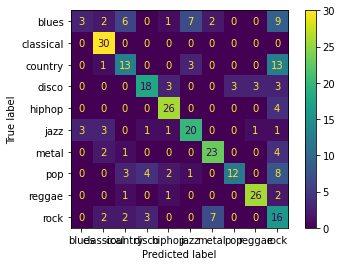

0.6233333333333333
[[ 3  2  6  0  1  7  2  0  0  9]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  1 13  0  0  3  0  0  0 13]
 [ 0  0  0 18  3  0  0  3  3  3]
 [ 0  0  0  0 26  0  0  0  0  4]
 [ 3  3  0  1  1 20  0  0  1  1]
 [ 0  2  1  0  0  0 23  0  0  4]
 [ 0  0  3  4  2  1  0 12  0  8]
 [ 0  0  1  0  1  0  0  0 26  2]
 [ 0  2  2  3  0  0  7  0  0 16]]
              precision    recall  f1-score   support

       blues       0.50      0.10      0.17        30
   classical       0.75      1.00      0.86        30
     country       0.50      0.43      0.46        30
       disco       0.69      0.60      0.64        30
      hiphop       0.76      0.87      0.81        30
        jazz       0.65      0.67      0.66        30
       metal       0.72      0.77      0.74        30
         pop       0.80      0.40      0.53        30
      reggae       0.87      0.87      0.87        30
        rock       0.27      0.53      0.36        30

    accuracy                           0.62       300


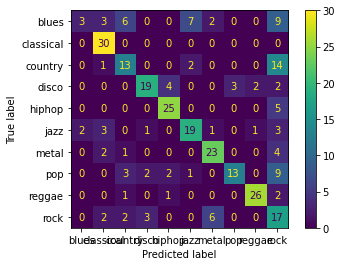

0.6266666666666667
[[ 3  3  6  0  0  7  2  0  0  9]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  1 13  0  0  2  0  0  0 14]
 [ 0  0  0 19  4  0  0  3  2  2]
 [ 0  0  0  0 25  0  0  0  0  5]
 [ 2  3  0  1  0 19  1  0  1  3]
 [ 0  2  1  0  0  0 23  0  0  4]
 [ 0  0  3  2  2  1  0 13  0  9]
 [ 0  0  1  0  1  0  0  0 26  2]
 [ 0  2  2  3  0  0  6  0  0 17]]
              precision    recall  f1-score   support

       blues       0.60      0.10      0.17        30
   classical       0.73      1.00      0.85        30
     country       0.50      0.43      0.46        30
       disco       0.76      0.63      0.69        30
      hiphop       0.78      0.83      0.81        30
        jazz       0.66      0.63      0.64        30
       metal       0.72      0.77      0.74        30
         pop       0.81      0.43      0.57        30
      reggae       0.90      0.87      0.88        30
        rock       0.26      0.57      0.36        30

    accuracy                           0.63       300


In [ ]:
mapping = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
feature = 'mfcc'
n_mfcc = 13
n_sec_frag = 2
debug = True
model = keras.models.load_model('/content/drive/MyDrive/Machine Learning Project/saved_model_fulltrained_'+feature+'_'+str(n_mfcc)+'_'+str(n_sec_frag))
predict_songs(model, path_test, feature, n_mfcc, n_sec_frag, mapping, debug)